In [1]:
import sys
import os
import pandas as pd
from pprint import pprint

# Import your custom modules. Adjust the module paths as needed.
from data.load_data import loadTrainingData
from plots.feature_plots import plot_missingness


In [2]:
# Define directories and max_files manually.
directories = ['../../training_setA/', '../../training_setB/']
max_files = 1000  # Change this to a number (e.g., 1000) if you want to limit the number of files
ignore_columns = ['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime']

dfs = []
patient_dict = {}

for directory in directories:
    # Build the path pattern for .psv files in the directory.
    pattern = os.path.join(directory, "*.psv")
    print(f"\nLoading data from: {pattern} with max_files={max_files}")
    patient_data = loadTrainingData(pattern, max_files)
    
    patient_dict.update(patient_data)
    
    # Concatenate all DataFrames from the current directory.
    combined_df = pd.concat(list(patient_data.values()), ignore_index=True)
    dfs.append(combined_df)

# Concatenate the combined DataFrames from all directories.
all_data = pd.concat(dfs, ignore_index=True)
print(f"\nCombined training set shape: {all_data.shape}")



Loading data from: ../../training_setA/*.psv with max_files=1000


Loading PSV Files: 100%|███████████████████| 1000/1000 [00:01<00:00, 859.39it/s]



Loading data from: ../../training_setB/*.psv with max_files=1000


Loading PSV Files: 100%|███████████████████| 1000/1000 [00:01<00:00, 848.85it/s]



Combined training set shape: (77415, 35)


Average missingness: 77.90%


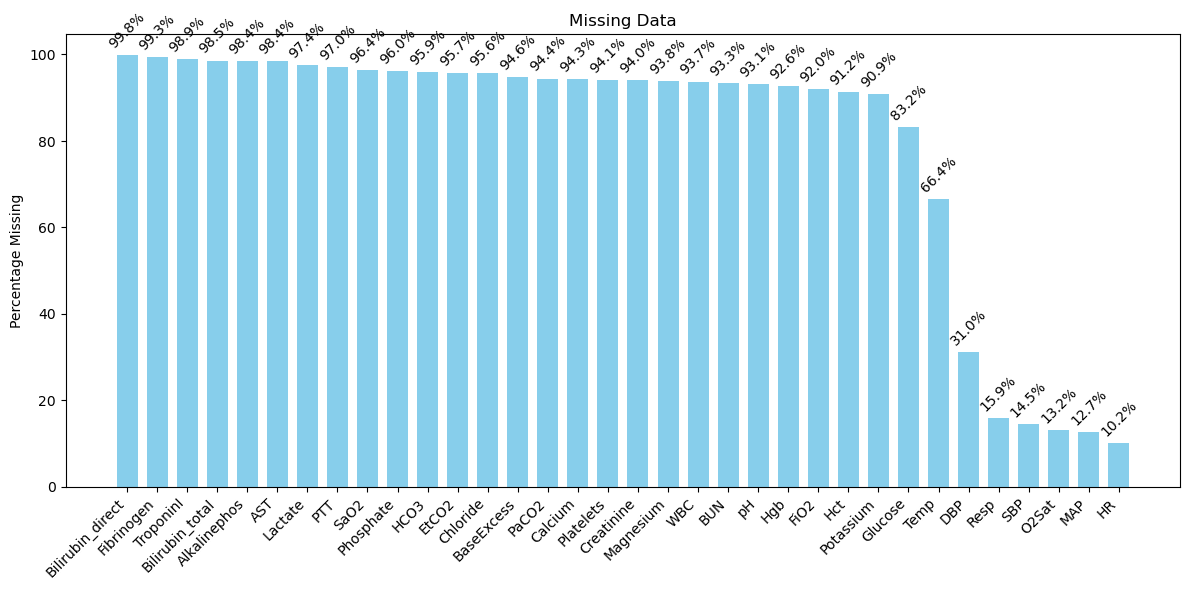

In [3]:
plot_missingness(all_data, title="Missing Data")

In [4]:
all_data.head(5)

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,SepsisLabel
0,80.0,100.0,36.50,121.00,58.0,41.00,13.5,NaN,1.0,25.0,...,3.7,NaN,NaN,27.9,8.8,38.1,9.9,223.0,160.0,0
1,76.0,100.0,36.25,113.25,61.0,41.50,12.0,NaN,1.0,25.0,...,NaN,NaN,NaN,27.9,8.8,NaN,9.9,NaN,NaN,0
2,80.0,100.0,36.25,132.75,71.5,46.25,12.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,78.0,100.0,36.10,103.50,58.0,43.00,12.0,NaN,-3.0,NaN,...,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,74.0,100.0,36.00,128.75,69.5,44.50,12.5,NaN,-3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [5]:
all_data.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'SepsisLabel'],
      dtype='object')

Average missingness: 77.88%


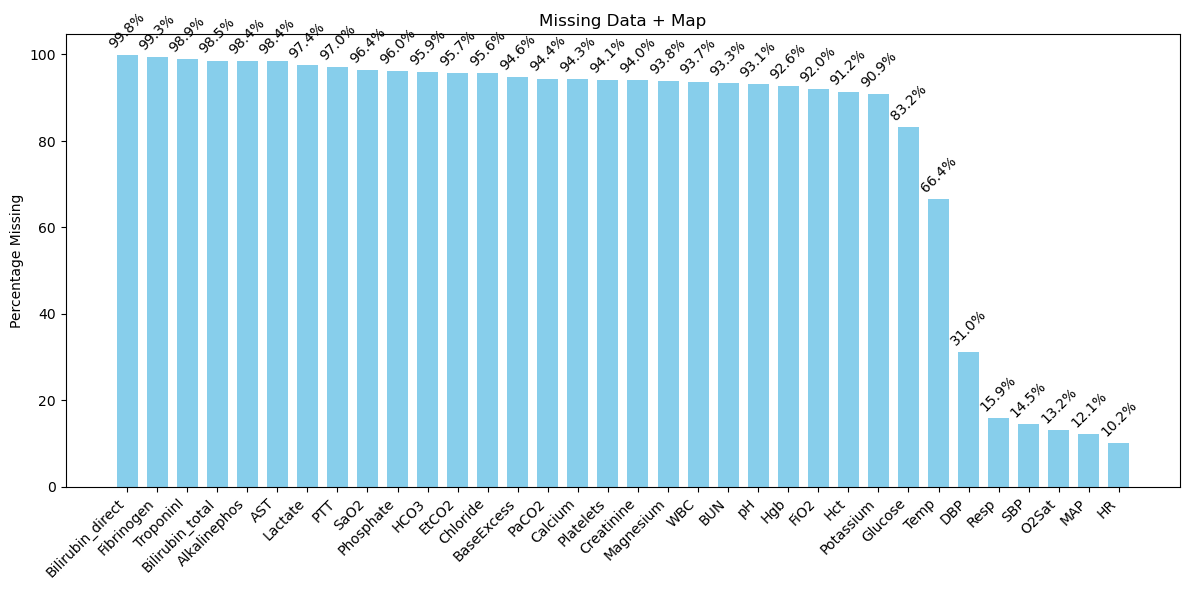

In [6]:
# Improve Missingness here
from data.clean_data import forwardFillMAP

all_data = forwardFillMAP(all_data)
plot_missingness(all_data, title="Missing Data + Map")

Average missingness: 77.41%


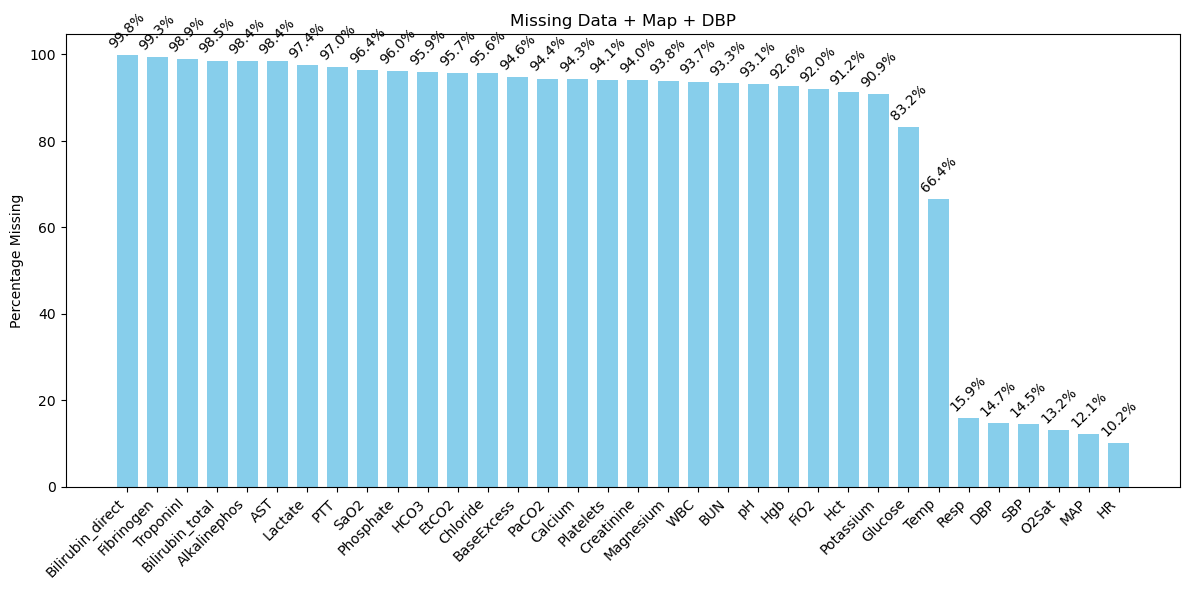

In [7]:
from data.clean_data import forwardFillDBP

all_data = forwardFillDBP(all_data)
plot_missingness(all_data, title="Missing Data + Map + DBP")

Average missingness: 77.41%


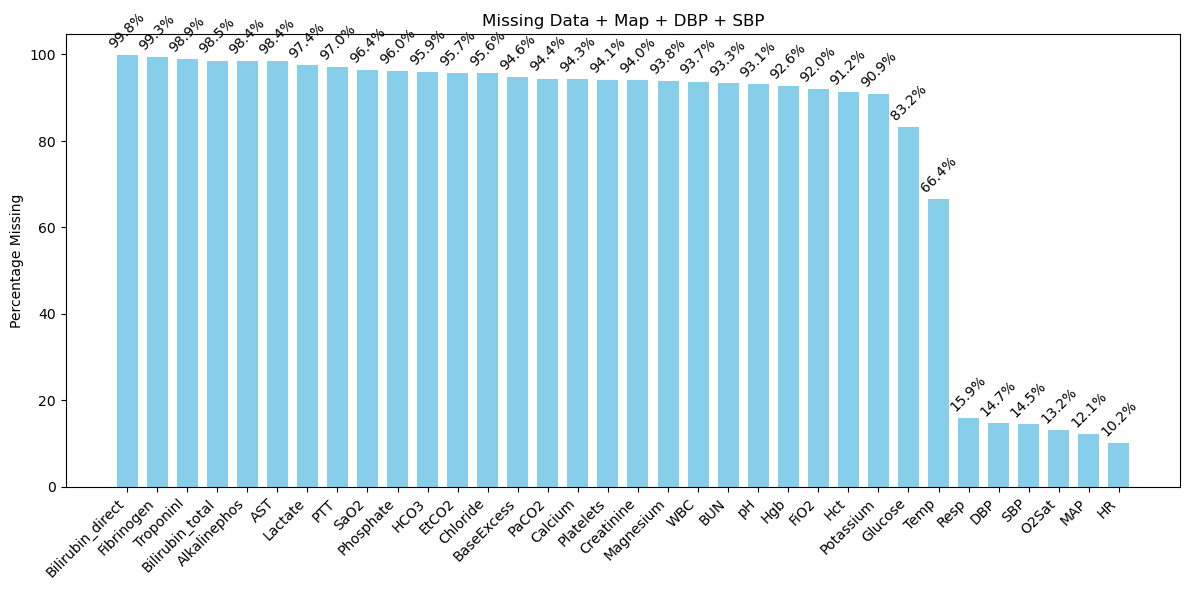

In [8]:
from data.clean_data import forwardFillSBP

all_data = forwardFillSBP(all_data)
plot_missingness(all_data, title="Missing Data + Map + DBP + SBP")

Correlation Matrix for pH, PaCO2, and HCO3:
             pH     PaCO2      HCO3
pH     1.000000 -0.432414  0.365038
PaCO2 -0.432414  1.000000  0.590757
HCO3   0.365038  0.590757  1.000000


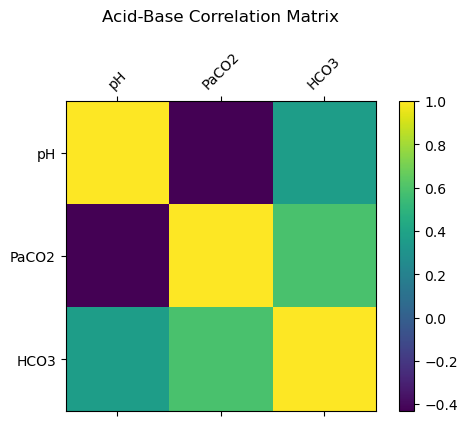

In [9]:
import matplotlib.pyplot as plt
    
df = all_data.copy()

complete = df[['pH', 'PaCO2', 'HCO3']].dropna()
corr_matrix = complete.corr()
print("Correlation Matrix for pH, PaCO2, and HCO3:")
print(corr_matrix)

# Optionally, visualize the correlation matrix.
plt.figure(figsize=(6, 4))
plt.matshow(corr_matrix, fignum=1)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.colorbar()
plt.title("Acid-Base Correlation Matrix", pad=20)
plt.show()


In [10]:
from data.correlation_data import test_pH_equation_accuracy

test_pH_equation_accuracy(df)

Descriptive statistics for True pH values:
count    868.000000
mean       7.381025
std        0.074111
min        6.990000
25%        7.340000
50%        7.390000
75%        7.430000
max        7.670000
Name: True pH, dtype: float64

Descriptive statistics for Predicted pH values:
count    868.000000
mean       7.378888
std        0.079105
min        6.940942
25%        7.331833
50%        7.384318
75%        7.429754
max        7.680871
Name: Predicted pH, dtype: float64

Descriptive statistics for Absolute Error:
count    868.000000
mean       0.025117
std        0.022209
min        0.000123
25%        0.010159
50%        0.020110
75%        0.033587
max        0.273001
Name: Absolute Error, dtype: float64

Mean Absolute Error of pH prediction: 0.025


0.025117233608349325

Average missingness: 77.28%


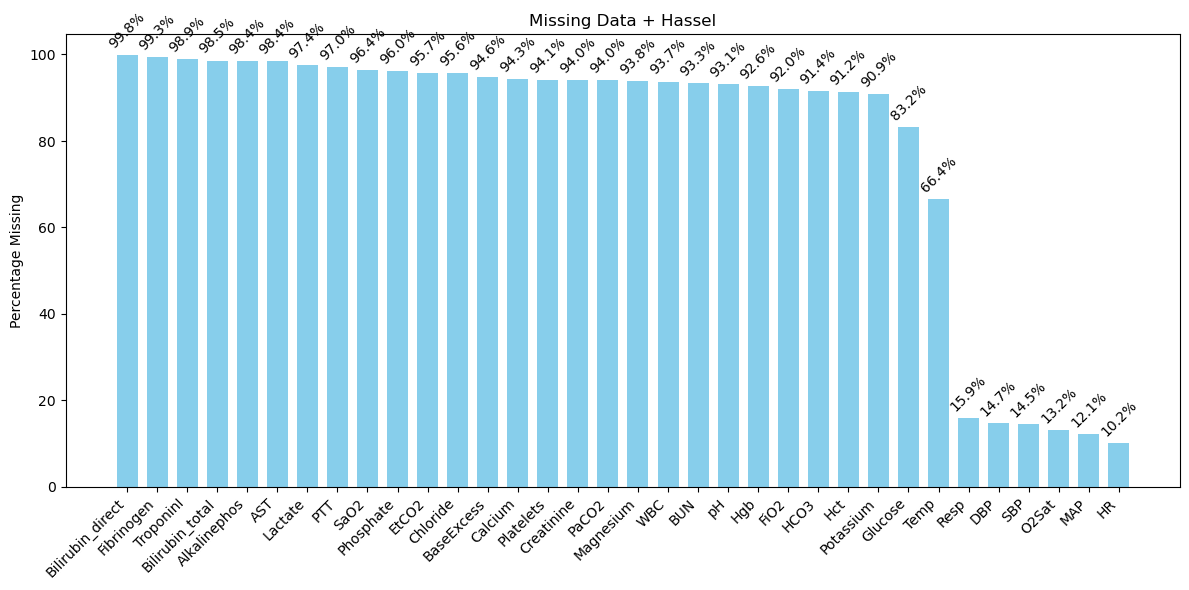

In [11]:
from data.clean_data import forwardFillHasselbalch

all_data = forwardFillHasselbalch(all_data)
plot_missingness(all_data, title="Missing Data + Hassel")

In [12]:
all_data['Bilirubin_total'].describe()

count    1148.000000
mean        2.183275
std         4.308123
min         0.100000
25%         0.500000
50%         0.800000
75%         1.625000
max        43.700000
Name: Bilirubin_total, dtype: float64

In [13]:
all_data['Bilirubin_direct'].describe()

count    165.00000
mean       2.48800
std        5.14941
min        0.03000
25%        0.20000
50%        0.40000
75%        2.04000
max       30.00000
Name: Bilirubin_direct, dtype: float64

In [14]:
from data.clean_data import forwardFillData

clean_df = forwardFillData(all_data)
# plot_missingness(clean_df, title="Cleaned Data")

In [15]:
from data.clean_data import backShiftSepsisLabel


patient_record = None
for df in patient_dict.values():
    if df['SepsisLabel'].sum() > 0:
        patient_record = df
        break


patient_record.tail(10)


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,SepsisLabel
44,112,100.0,NaN,138,90,69,25.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
45,111,97.0,NaN,140,91,69,27.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
46,112,95.0,NaN,129,86,65,29.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
47,109,100.0,NaN,127,84,62,29.0,NaN,NaN,NaN,...,NaN,NaN,NaN,27.1,9.1,32.4,8.8,NaN,106.0,1
48,99,96.0,36.61,140,95,71,28.0,NaN,NaN,NaN,...,NaN,NaN,NaN,27.1,9.1,NaN,8.8,NaN,NaN,1
49,112,97.0,NaN,134,90,67,24.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
50,105,100.0,NaN,142,96,72,25.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
51,117,95.0,NaN,126,83,62,24.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
52,114,94.0,36.83,144,96,71,26.0,NaN,0.0,23.0,...,3.9,NaN,NaN,26.1,8.8,NaN,9.9,NaN,103.0,1
53,113,87.0,NaN,117,77,59,30.0,NaN,0.0,23.0,...,3.9,NaN,NaN,26.1,8.8,NaN,9.9,NaN,NaN,1


In [16]:
shifted_patient_record = backShiftSepsisLabel(patient_record)

shifted_patient_record.tail(10)

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,SepsisLabel
44,112,100.0,NaN,138,90,69,25.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
45,111,97.0,NaN,140,91,69,27.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
46,112,95.0,NaN,129,86,65,29.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
47,109,100.0,NaN,127,84,62,29.0,NaN,NaN,NaN,...,NaN,NaN,NaN,27.1,9.1,32.4,8.8,NaN,106.0,0.0
48,99,96.0,36.61,140,95,71,28.0,NaN,NaN,NaN,...,NaN,NaN,NaN,27.1,9.1,NaN,8.8,NaN,NaN,0.0
49,112,97.0,NaN,134,90,67,24.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
50,105,100.0,NaN,142,96,72,25.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
51,117,95.0,NaN,126,83,62,24.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
52,114,94.0,36.83,144,96,71,26.0,NaN,0.0,23.0,...,3.9,NaN,NaN,26.1,8.8,NaN,9.9,NaN,103.0,1.0
53,113,87.0,NaN,117,77,59,30.0,NaN,0.0,23.0,...,3.9,NaN,NaN,26.1,8.8,NaN,9.9,NaN,NaN,1.0


In [17]:
# Count avg num of sepsis labels for a septic patient
# Take a dictionary of patient dataframes
# If they have at least one septic label
# Add the column to a list to calculate the avg number of rows for a septic patient and the avg number of septic labels = 1 for a patient
# also record the min and max number of septic label = 1 for a patient that has sepsis

In [18]:
from data.helper_data import count_sepsis_labels

count_sepsis_labels(patient_dict)

Average number of rows for septic patients: 63.77
Average number of septic labels (1's) per septic patient: 9.58
Minimum number of septic labels: 8 (Patient ID: 006368)
Maximum number of septic labels: 10 (Patient ID: 018630)


In [19]:
from models.mice.encode_data import encode_dict_deltas

encoded_patient_dict = encode_dict_deltas(patient_dict)

Encoding patients: 100%|████████████████████| 2000/2000 [00:29<00:00, 66.80it/s]


In [20]:
"""
Function takes a dict of patient dataframes
Create Sliding Window feature vectors or some many of feature vectors
Add Engineered features

RunLGBM

Eval outputs

Grid Search - Machine Learning library to run 10k combos with json input

"""

'\nFunction takes a dict of patient dataframes\nCreate Sliding Window feature vectors or some many of feature vectors\nAdd Engineered features\n\nRunLGBM\n\nEval outputs\n\nGrid Search - Machine Learning library to run 10k combos with json input\n\n'

In [21]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

patient_record = None
for df in encoded_patient_dict.values():
    if df['SepsisLabel'].sum() > 0:
        patient_record = df
        break
        
patient_record.head(10)

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,SepsisLabel,patient_id,SepsisLabel_delta,HR_delta1,HR_delta2,O2Sat_delta1,O2Sat_delta2,Temp_delta1,Temp_delta2,SBP_delta1,SBP_delta2,MAP_delta1,MAP_delta2,DBP_delta1,DBP_delta2,Resp_delta1,Resp_delta2,EtCO2_delta1,EtCO2_delta2,BaseExcess_delta1,BaseExcess_delta2,HCO3_delta1,HCO3_delta2,FiO2_delta1,FiO2_delta2,pH_delta1,pH_delta2,PaCO2_delta1,PaCO2_delta2,SaO2_delta1,SaO2_delta2,AST_delta1,AST_delta2,BUN_delta1,BUN_delta2,Alkalinephos_delta1,Alkalinephos_delta2,Calcium_delta1,Calcium_delta2,Chloride_delta1,Chloride_delta2,Creatinine_delta1,Creatinine_delta2,Bilirubin_direct_delta1,Bilirubin_direct_delta2,Glucose_delta1,Glucose_delta2,Lactate_delta1,Lactate_delta2,Magnesium_delta1,Magnesium_delta2,Phosphate_delta1,Phosphate_delta2,Potassium_delta1,Potassium_delta2,Bilirubin_total_delta1,Bilirubin_total_delta2,TroponinI_delta1,TroponinI_delta2,Hct_delta1,Hct_delta2,Hgb_delta1,Hgb_delta2,PTT_delta1,PTT_delta2,WBC_delta1,WBC_delta2,Fibrinogen_delta1,Fibrinogen_delta2,Platelets_delta1,Platelets_delta2
0,110,100.0,35.9,110,83,70,14.0,NaN,-4.0,20.0,0.5,7.33,NaN,99.0,NaN,30.0,NaN,NaN,109.0,NaN,NaN,NaN,2.0,1.3,NaN,5.6,NaN,NaN,30.5,10.2,NaN,18.3,NaN,NaN,0,016806,-45,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,110,100.0,36.2,118,90,76,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,016806,-44,0,0,0.0,0.0,0.3,0.0,8,0,7,0,6,0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
2,102,100.0,36.5,100,76,63,14.0,NaN,-4.0,NaN,NaN,7.30,43.0,98.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,016806,-43,-8,-8,0.0,0.0,0.3,0.6,-18,-10,-14,-7,-13,-7,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-0.03,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,101,100.0,36.1,121,87,71,15.0,NaN,-4.0,NaN,0.4,7.30,NaN,98.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,016806,-42,-1,-9,0.0,0.0,-0.4,-0.1,21,3,11,-3,8,-5,1.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100,100.0,36.0,129,90,72,16.0,NaN,NaN,21.0,NaN,NaN,NaN,NaN,222.0,29.0,99.0,8.2,106.0,0.7,NaN,74.0,NaN,2.7,3.5,4.4,1.3,NaN,32.7,10.8,28.9,18.2,NaN,105.0,0,016806,-41,-1,-2,0.0,0.0,-0.1,-0.5,8,29,3,14,1,9,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,91,100.0,36.0,114,79,65,16.0,NaN,-4.0,21.0,NaN,7.33,40.0,98.0,222.0,29.0,99.0,NaN,106.0,NaN,NaN,NaN,0.9,2.7,NaN,4.4,NaN,NaN,32.7,10.8,NaN,18.2,NaN,NaN,0,016806,-40,-9,-10,0.0,0.0,0.0,-0.1,-15,-7,-11,-8,-7,-6,0.0,1.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.3,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
6,89,100.0,36.1,98,71,59,16.0,NaN,-4.0,NaN,NaN,7.33,NaN,98.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,016806,-39,-2,-11,0.0,0.0,0.1,0.1,-16,-31,-8,-19,-6,-1

In [22]:
from models.mice.encode_data import merge_patient_dict

encoded_df = merge_patient_dict(encoded_patient_dict, 'SepsisLabel_delta')

Average missingness: 78.95%


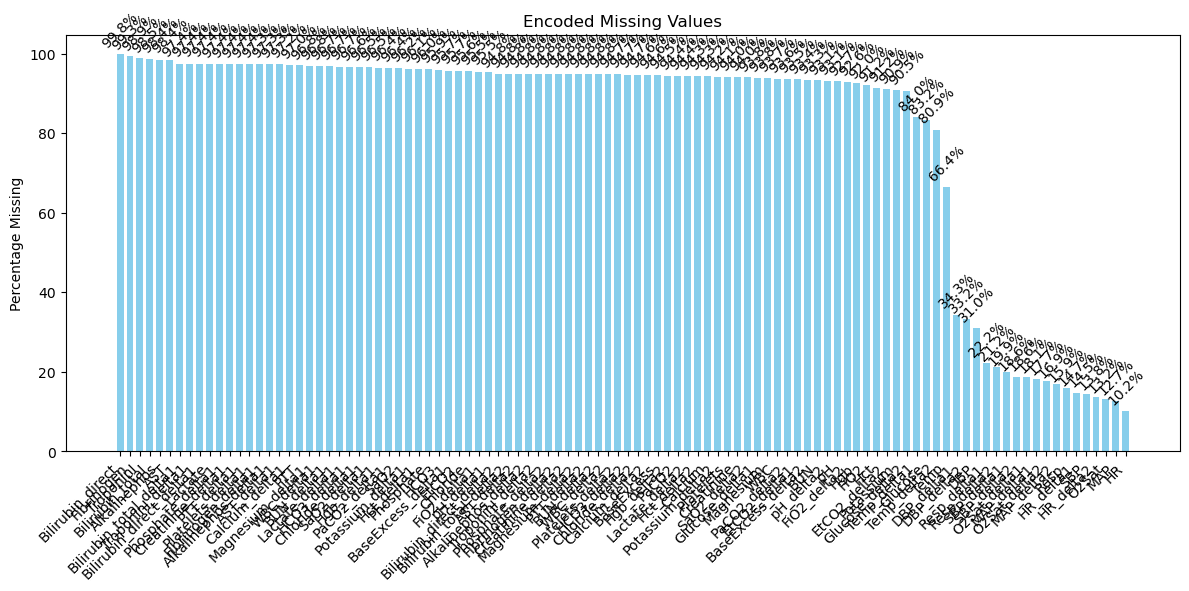

In [23]:
plot_missingness(encoded_df, title="Encoded Missing Values")

In [24]:
from models.mice.encode_data import impute_delta_features

imputed_df = impute_delta_features(encoded_df)

[IterativeImputer] Completing matrix with shape (77415, 68)
[IterativeImputer] Ending imputation round 1/10, elapsed time 39.90
[IterativeImputer] Change: 1.1672837887232335e+18, scaled tolerance: 0.725 
[IterativeImputer] Ending imputation round 2/10, elapsed time 82.35
[IterativeImputer] Change: 1.2369213329078967e+32, scaled tolerance: 0.725 
[IterativeImputer] Ending imputation round 3/10, elapsed time 119.23
[IterativeImputer] Change: 1.7080076116891514e+46, scaled tolerance: 0.725 
[IterativeImputer] Ending imputation round 4/10, elapsed time 154.20
[IterativeImputer] Change: 9.193135936666137e+60, scaled tolerance: 0.725 
[IterativeImputer] Ending imputation round 5/10, elapsed time 190.96
[IterativeImputer] Change: 2.503212623316102e+74, scaled tolerance: 0.725 
[IterativeImputer] Ending imputation round 6/10, elapsed time 227.61
[IterativeImputer] Change: 2.3647924402675832e+89, scaled tolerance: 0.725 
[IterativeImputer] Ending imputation round 7/10, elapsed time 265.78
[Iter

/Users/lukeedwards/anaconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [25]:
# imputed_df.head(10)
imputed_df.head(10)
# plot_missingness(imputed_df, title="Imputed Missing Values")

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,SepsisLabel,patient_id,SepsisLabel_delta,HR_delta1,HR_delta2,O2Sat_delta1,O2Sat_delta2,Temp_delta1,Temp_delta2,SBP_delta1,SBP_delta2,MAP_delta1,MAP_delta2,DBP_delta1,DBP_delta2,Resp_delta1,Resp_delta2,EtCO2_delta1,EtCO2_delta2,BaseExcess_delta1,BaseExcess_delta2,HCO3_delta1,HCO3_delta2,FiO2_delta1,FiO2_delta2,pH_delta1,pH_delta2,PaCO2_delta1,PaCO2_delta2,SaO2_delta1,SaO2_delta2,AST_delta1,AST_delta2,BUN_delta1,BUN_delta2,Alkalinephos_delta1,Alkalinephos_delta2,Calcium_delta1,Calcium_delta2,Chloride_delta1,Chloride_delta2,Creatinine_delta1,Creatinine_delta2,Bilirubin_direct_delta1,Bilirubin_direct_delta2,Glucose_delta1,Glucose_delta2,Lactate_delta1,Lactate_delta2,Magnesium_delta1,Magnesium_delta2,Phosphate_delta1,Phosphate_delta2,Potassium_delta1,Potassium_delta2,Bilirubin_total_delta1,Bilirubin_total_delta2,TroponinI_delta1,TroponinI_delta2,Hct_delta1,Hct_delta2,Hgb_delta1,Hgb_delta2,PTT_delta1,PTT_delta2,WBC_delta1,WBC_delta2,Fibrinogen_delta1,Fibrinogen_delta2,Platelets_delta1,Platelets_delta2
0,80.0,100.0,36.5,121.0,58.0,41.0,13.5,NaN,1.0,25.0,1.0,7.40,47.0,77.0,NaN,53.0,NaN,NaN,111.0,2.10,NaN,107.0,2.40,NaN,NaN,3.7,NaN,NaN,27.9,8.8,38.1,9.9,223.0,160.0,0,014977,-250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,88.0,98.0,38.0,166.0,88.0,58.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,110734,-250,-8.000000,-2.000000,-1.000000,0.000000,0.000000,-0.200000,-16.000000,60.000000,-2.00000,10.000000,2.000000,-4.000000,0.00000,0.000000,-133.477981,-244.565476,18.740965,-11.035901,-17.400068,32.261867,-1.210969,-1.483975,0.345745,1.204146,-181.414709,-228.972173,79.693791,-420.771088,-14.994224,-2.755986e+147,105.174166,-29.339382,-122.620430,6.710632e+144,177.377752,210.183980,48.711808,-56.017485,124.357915,0.670882,-7.283265,0.0,-324.600231,-982.147575,-4.768679,-17.291215,3.331032,3.352996,2.272889,0.207825,2.234877,-14.524808,-14.950510,8.001374e+144,81.554239,53.590498,13.736108,196.208482,5.719089,36.388631,-3.123271,-899.909078,82.335278,-18.631912,777.028315,1833.898312,88.204500,-565.273162
2,92.0,99.0,38.0,160.0,88.0,54.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,110734,-250,4.000000,-4.000000,1.000000,0.000000,0.000000,0.000000,-6.000000,-22.000000,0.00000,-2.000000,-4.000000,-2.000000,0.00000,0.000000,26.143357,47.411819,-3.349489,2.126895,3.487628,-6.423771,0.200446,0.269140,-0.057354,-0.227966,32.237635,44.057124,-14.250790,80.488678,2.968666,5.512768e+146,-20.317412,5.961461,24.160820,-1.342320e+144,-32.882578,-40.837504,-9.760360,11.240327,-24.954661,-0.135476,1.457397,0.0,60.337269,192.664925,0.870603,3.372847,-0.644508,-0.673859,-0.424133,-0.040222,-0.424486,2.800387,2.950857,-1.600506e+144,-16.331992,-10.701372,-2.595191,-38.305770,-1.079564,-6.983256,0.553884,183.271830,-16.167362,3.693232,-156.752935,-368.626102,-17.785525,110.790315
3,86.0,100.0,38.0,158.0,86.0,56.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,110734,-250,-6.000000,-2.000000,1.000000,2.000000,0.000000,0.000000,-2.000000,-8.000

In [26]:
from models.mice.encode_data import split_and_restructure

imputed_df.head(10)
imputed_dict = split_and_restructure(imputed_df)

Rebuild Dictionary: 100%|█████████████████| 2000/2000 [00:00<00:00, 2539.88it/s]


Average missingness: 25.97%


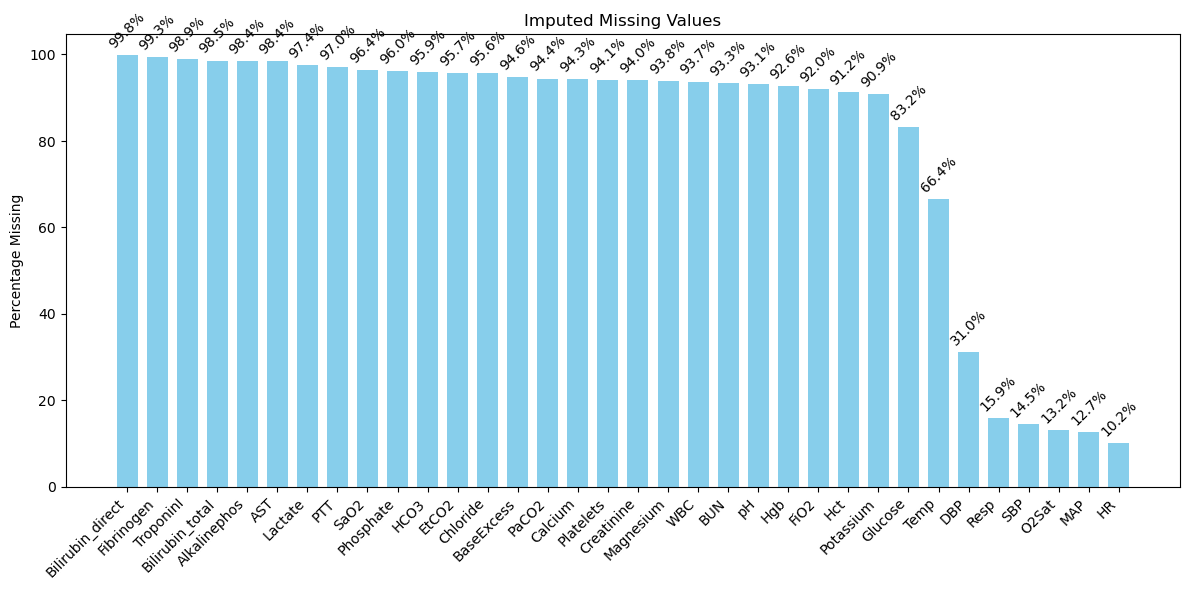

In [27]:
plot_missingness(imputed_df, title="Imputed Missing Values")

In [29]:
all_data["EtCO2"].describe()

count    3346.000000
mean       33.443365
std         7.966597
min        10.000000
25%        29.000000
50%        34.000000
75%        37.000000
max       100.000000
Name: EtCO2, dtype: float64